# Scraper / Plotter
-----
- Extracts data from weather balloon readings
- Transforms data into standard format
- Displays data on easily understandable graphs

In [3]:
import requests
import pandas as pd
from datetime import date, datetime, timedelta
from bs4 import BeautifulSoup
import numpy as np
from math import floor
from pathlib import Path  
from alive_progress import alive_bar
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
from windrose import WindroseAxes
from PIL import Image

### Define baseline params
- URL to be used
- Columns to be extracted
- Weather stations to examine
- Current date/time

In [4]:
base_url = "http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST"

cols = ["Date", 
        "Station", 
        "Pressure", 
        "Height", 
        "Temp", 
        "DewPoint", 
        "Relative_Humidity", 
        "Mean_Mixed_Layer", 
        "Wind_Direction", 
        "Wind_Speed", 
        "Potential_Temp",
        "Equivalent_Potential_Temp",
        "Virtual_Potential_Temp"]

stations = [
    {"id": 72797, "name": "Quillayute"},
    {"id": 73033, "name": "Vernon"},
    {"id": 71109, "name": "Port Hardy"}]

now = [
    datetime.now().year, 
    datetime.now().month, 
    datetime.now().day]

## Define date range function
---
- Accept start and end date
- Return range of dates between start and end

In [5]:
# Creates date range from str format dates
# e.g. "2021-01-01"
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

## Create list of URLs to scrape
---
- Iterate throguh date ranges
- Iterate through stations
- Return list of all URLs to be scraped

In [6]:
# Create date range
# ~~~~~~~~~~~~~~~~~
dates_arr = []
start_date = date(2022, 9, 1)
#start_date = date(now[0], now[1], now[2])
end_date = date(now[0], now[1], now[2]+1)
print(f"Start Date:\t{start_date}\nEnd Date:\t{end_date}")

for single_date in daterange(start_date, end_date):
    single_date = (str(single_date).split("-")) 
    dates_arr.append([ int(x) for x in single_date ])
       
# Create list of URLs for each station
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
urls = []
dates_idx = []
station_idx = []
for d in dates_arr:
    for station in stations:
        url = base_url
        url += "&YEAR={}".format(d[0])
        url += "&MONTH={}".format(d[1])
        #url += "&FROM=" + str(now[1]) + str(now[2])
        #url += "&TO=" + str(now[1]) + str(now[2])
        url += "&FROM={:0>2d}00".format(d[2])
        url += "&TO={:0>2d}23".format(d[2])
        url += "&STNM={}".format(station["id"])
        url += "&REPLOT=1"
        urls.append(url)
        
        
        dates_idx.append("%02d-%02d-%02d" % (d[0], d[1], d[2]))
        station_idx.append(station["name"])

print(urls[0])
for url in urls:
    print(url)

Start Date:	2022-09-01
End Date:	2023-06-07
http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2022&MONTH=9&FROM=0100&TO=0123&STNM=72797&REPLOT=1
http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2022&MONTH=9&FROM=0100&TO=0123&STNM=72797&REPLOT=1
http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2022&MONTH=9&FROM=0100&TO=0123&STNM=73033&REPLOT=1
http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2022&MONTH=9&FROM=0100&TO=0123&STNM=71109&REPLOT=1
http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2022&MONTH=9&FROM=0200&TO=0223&STNM=72797&REPLOT=1
http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2022&MONTH=9&FROM=0200&TO=0223&STNM=73033&REPLOT=1
http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2022&MONTH=9&FROM=0200&TO=0223&STNM=71109&REPLOT=1
http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=

## Extract data from list of URLs
---
- Iterate through URLs
- Extract 700 and 850 data items
- Append data to array

In [7]:
data = []
reading_idx = []
problem_urls = []

print("Extracting data from URLs: ")
with alive_bar(len(urls), force_tty=True) as bar:
    for i, url in enumerate(urls):
        search = 0
        while search >= 0:
            # scrape site data
            # ~~~~~~~~~~~~~~~~
            search += 1
            page = requests.get(url)
            soup = BeautifulSoup(page.content, "html.parser")
            results = str(soup.find('pre'))
            sevhundy = results[results.find("700"):].split()[:11]
            eightfiddy = results[results.find("850"):].split()[:11]
            
            # catch erroneous reads
            # site can hit too many requests
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            if 'e' not in sevhundy[0] and 'e' not in eightfiddy[0]:
                search = -1
            elif search == 10:
                print(url)
                problem_urls.append(url)
                search = -1

        # we want 700 first // 850 second
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        data.append(sevhundy)
        data[-1].insert(0, dates_idx[i])
        data[-1].insert(1, station_idx[i])
        
        data.append(eightfiddy)
        data[-1].insert(0, dates_idx[i])
        data[-1].insert(1, station_idx[i])
        
        bar()
        

print("\nComplete")

Extracting data from URLs: 
|████████████████████████████████████████| 837/837 [100%] in 33:50.0 (0.41/s)                                           

Complete


In [20]:
print(data[0])

['2022-09-01', 'Quillayute', '700', '11.2', '-9.8', '22', '2.47', '231', '20', '309.9', '318.0', '310.4', '738.0']


In [8]:
print("Problem URLs:")
for url in problem_urls:
    print(url)

Problem URLs:


## Clean Data
---
- Remove unwanted chars from fields
- Convert wind speed to km/h from knots

In [9]:
# Remove rogue "e" values from pressure field
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
pressures = [700, 850]
ctr = 0
for item in data:
    if(not str(item[2]).isnumeric()):
        item[2] = pressures[ctr%2]
    ctr += 1

In [10]:
df = pd.DataFrame(data, columns=cols)

# Convert DataFrame to numeric values
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for col in cols[2:]:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        print(col)
    
# Convert wind speed from Knots to KM/H
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
df['Wind_Speed'] = df['Wind_Speed'].multiply(1.852)
df.head(20)

,Date,Station,Pressure,Height,Temp,DewPoint,Relative_Humidity,Mean_Mixed_Layer,Wind_Direction,Wind_Speed,Potential_Temp,Equivalent_Potential_Temp,Virtual_Potential_Temp
0,2022-09-01,Quillayute,700,11.2,-9.8,22.0,2.47,231.00,20.0,573.9348,318.0,310.4,738.0
1,2022-09-01,Quillayute,850,1528.0,17.8,8.8,56.00,8.43,205.0,20.3720,304.8,330.4,306.3
2,2022-09-01,Vernon,700,3187.0,10.8,-2.2,40.00,4.67,220.0,35.1880,314.4,329.5,315.3
3,2022-09-01,Vernon,850,1518.0,25.4,4.4,26.00,6.20,130.0,14.8160,312.7,332.5,313.9
4,2022-09-01,Port Hardy,700,3191.0,6.6,-2.4,53.00,4.60,245.0,29.6320,309.8,324.4,310.6
5,2022-09-01,Port Hardy,850,1545.0,16.8,4.8,45.00,6.38,245.0,18.5200,303.7,323.2,304.9
6,2022-09-02,Quillayute,700,3164.0,9.4,-15.6,15.00,1.63,205.0,38.8920,312.9,318.4,313.2
7,2022-09-02,Quillayute,850,1526.0,18.0,1.0,32.00,4.86,180.0,14.8160,305.0,320.1,305.9
8,2022-09-02,Vernon,700,3154.0,6.6,1.6,70.00,6.18,290.0,22.2240,309.8,329.1,310.9
9,2022-09-02,Vernon,850,1519.0,21.8,5.8,35.00,6.85,40.0,3.7040,309.0,330.3,310.2


In [11]:
df.tail()

,Date,Station,Pressure,Height,Temp,DewPoint,Relative_Humidity,Mean_Mixed_Layer,Wind_Direction,Wind_Speed,Potential_Temp,Equivalent_Potential_Temp,Virtual_Potential_Temp
1669,2023-06-06,Quillayute,850,1537.0,10.0,-17.0,13.0,1.19,15.0,27.780,296.6,300.5,296.8
1670,2023-06-06,Vernon,700,3121.0,0.0,-23.0,16.0,0.86,275.0,22.224,302.4,305.4,302.6
1671,2023-06-06,Vernon,850,1544.0,10.8,-4.2,35.0,3.31,15.0,9.260,297.4,307.6,298.0
1672,2023-06-06,Port Hardy,700,3115.0,1.0,-42.0,2.0,0.14,295.0,16.668,303.6,304.1,303.6
1673,2023-06-06,Port Hardy,850,1524.0,9.8,-14.3,17.0,1.49,345.0,22.224,296.4,301.2,296.6


## Export data to CSV
---
Create new file for each date the extraction is run and save to /data/ folder

In [12]:
filepath = Path('./data/raw_scrape-{}-{}-{}.csv'.format(datetime.now().year, datetime.now().month, datetime.now().day))  
filepath.parent.mkdir(parents=True, exist_ok=True) 
df.to_csv(filepath)

### Split Data by Region
---
Seperate the general DataFrame for simpler manipulation

In [13]:
df.set_index(['Date','Station','Pressure'])

Height  Temp  DewPoint  Relative_Humidity  \
Date       Station    Pressure                                              
2022-09-01 Quillayute 700         11.2  -9.8      22.0               2.47   
                      850       1528.0  17.8       8.8              56.00   
           Vernon     700       3187.0  10.8      -2.2              40.00   
                      850       1518.0  25.4       4.4              26.00   
           Port Hardy 700       3191.0   6.6      -2.4              53.00   
...                                ...   ...       ...                ...   
2023-06-06 Quillayute 850       1537.0  10.0     -17.0              13.00   
           Vernon     700       3121.0   0.0     -23.0              16.00   
                      850       1544.0  10.8      -4.2              35.00   
           Port Hardy 700       3115.0   1.0     -42.0               2.00   
                      850       1524.0   9.8     -14.3              17.00   

                                Mean_Mixed_Layer  Wind_Direction  Wind_Speed  \
Date       Station    Pressure                                                 
2022-09-01 Quillayute 700                 231.00            20.0    573.9348   
                      850                   8.43           205.0     20.3720   
           Vernon     700                   4.67           220.0     35.1880   
                      850                   6.20           130.0     14.8160   
           Port Hardy 700                   4.60           245.0     29.6320   
...                                          ...             ...         ...   
2023-06-06 Quillayute 850                   1.19            15.0     27.7800   
           Vernon     700                   0.86           275.0     22.2240   
                      850                   3.31            15.0      9.2600   
           Port Hardy 700                   0.14           295.0     16.6680   
                      850                   1.49           345.0     22.2240   

                                Potential_Temp  Equivalent_Potential_Temp  \
Date       Station    Pressure                                              
2022-09-01 Quillayute 700                318.0                      310.4   
                      850                304.8                      330.4   
           Vernon     700                314.4                      329.5   
                      850                312.7                      332.5   
           Port Hardy 700                309.8                      324.4   
...                                        ...                        ...   
2023-06-06 Quillayute 850                296.6                      300.5   
           Vernon     700                302.4                      305.4   
                      850                297.4                      307.6   
           Port Hardy 700                303.6                      304.1   
                      850                296.4                      301.2   

                                Virtual_Potential_Temp  
Date       Station    Pressure                          
2022-09-01 Quillayute 700                        738.0  
                      850                        306.3  
           Vernon     700                        315.3  
                      850                        313.9  
           Port Hardy 700                        310.6  
...                                                ...  
2023-06-06 Quillayute 850                        296.8  
           Vernon     700                        302.6  
                      850                        298.0  
           Port Hardy 700                        303.6  
                      850                        296.6  

[1674 rows x 10 columns]

## Check Data

Are there any null Temp values in our dataset?

---

In [14]:
print("Null Temp values:")
df[pd.isnull(df.Temp)]

Null Temp values:


,Date,Station,Pressure,Height,Temp,DewPoint,Relative_Humidity,Mean_Mixed_Layer,Wind_Direction,Wind_Speed,Potential_Temp,Equivalent_Potential_Temp,Virtual_Potential_Temp
622,2022-12-13,Port Hardy,700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
664,2022-12-20,Port Hardy,700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
665,2022-12-20,Port Hardy,850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
856,2023-01-21,Port Hardy,700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
862,2023-01-22,Port Hardy,700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Temperature

---
### Plot for Quillayute
Plot for Temperature values at Quillayute

---

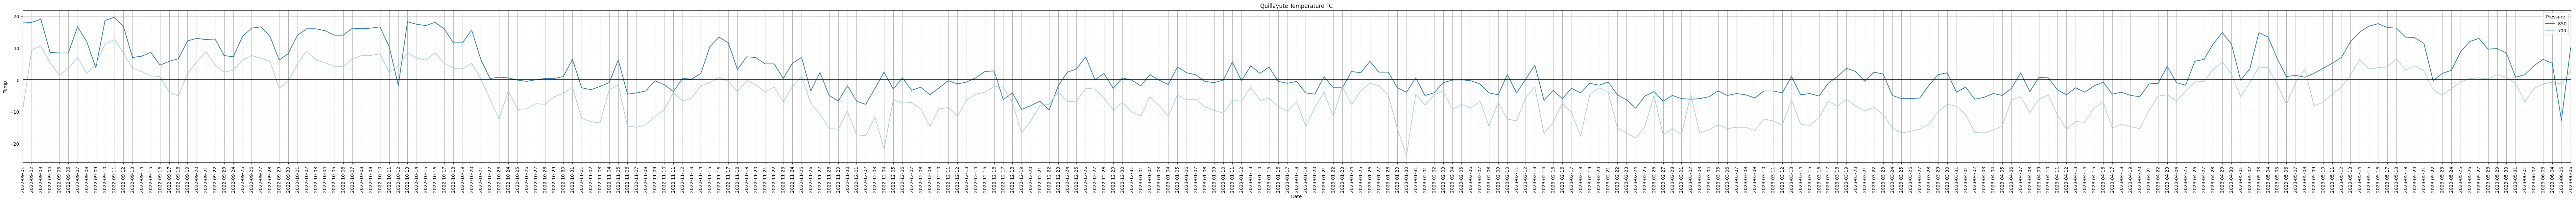

In [19]:
# Set figure details
plt.figure(figsize=(100,6))
plt.title("Quillayute Temperature °C")
plt.xticks(rotation = 'vertical')
palette = sns.color_palette("Paired", n_colors=6)
order = [1, 0, 3, 2, 5, 4]
palette = [palette[idx] for idx in order]
hue_order = [850, 700]

# Line chart showing daily temps of Quillayute weather balloon at both 700 and 850 hPa
g = sns.lineplot(x='Date', y='Temp', hue='Pressure', data=df[df['Station'] == "Quillayute"], palette=palette[0:2], hue_order=hue_order)
g.axhline(0, color='black')

# Display and Save graph
plt.xlim([0, len(df)/6 -1])
plt.grid()
plt.savefig("./figures/temp/QuillayuteTemps-{:0>4d}-{:0>2d}-{:0>2d}.png".format(datetime.now().year, datetime.now().month, datetime.now().day),
            format='png',dpi=150)
plt.show()

In [16]:
df[df['Station'] == "Quillayute"]

,Date,Station,Pressure,Height,Temp,DewPoint,Relative_Humidity,Mean_Mixed_Layer,Wind_Direction,Wind_Speed,Potential_Temp,Equivalent_Potential_Temp,Virtual_Potential_Temp
0,2022-09-01,Quillayute,700,11.2,-9.8,22.0,2.47,231.00,20.0,573.9348,318.0,310.4,738.0
1,2022-09-01,Quillayute,850,1528.0,17.8,8.8,56.00,8.43,205.0,20.3720,304.8,330.4,306.3
6,2022-09-02,Quillayute,700,3164.0,9.4,-15.6,15.00,1.63,205.0,38.8920,312.9,318.4,313.2
7,2022-09-02,Quillayute,850,1526.0,18.0,1.0,32.00,4.86,180.0,14.8160,305.0,320.1,305.9
12,2022-09-03,Quillayute,700,3134.0,10.6,-23.4,7.00,0.83,180.0,59.2640,314.2,317.2,314.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657,2023-06-04,Quillayute,850,1529.0,5.2,2.8,84.00,5.54,195.0,16.6680,291.6,307.8,292.6
1662,2023-06-05,Quillayute,700,3126.0,-1.3,-35.3,6.00,0.27,290.0,25.9280,301.0,302.0,301.1
1663,2023-06-05,Quillayute,850,9.3,-12.7,20.0,1.56,335.00,13.0,534.6724,293.5,289.0,925.0
1668,2023-06-06,Quillayute,700,3125.0,2.8,-22.2,14.00,0.93,305.0,27.7800,305.6,308.7,305.7


---
### Plot for Vernon
Plot for Temperature values at Vernon

---

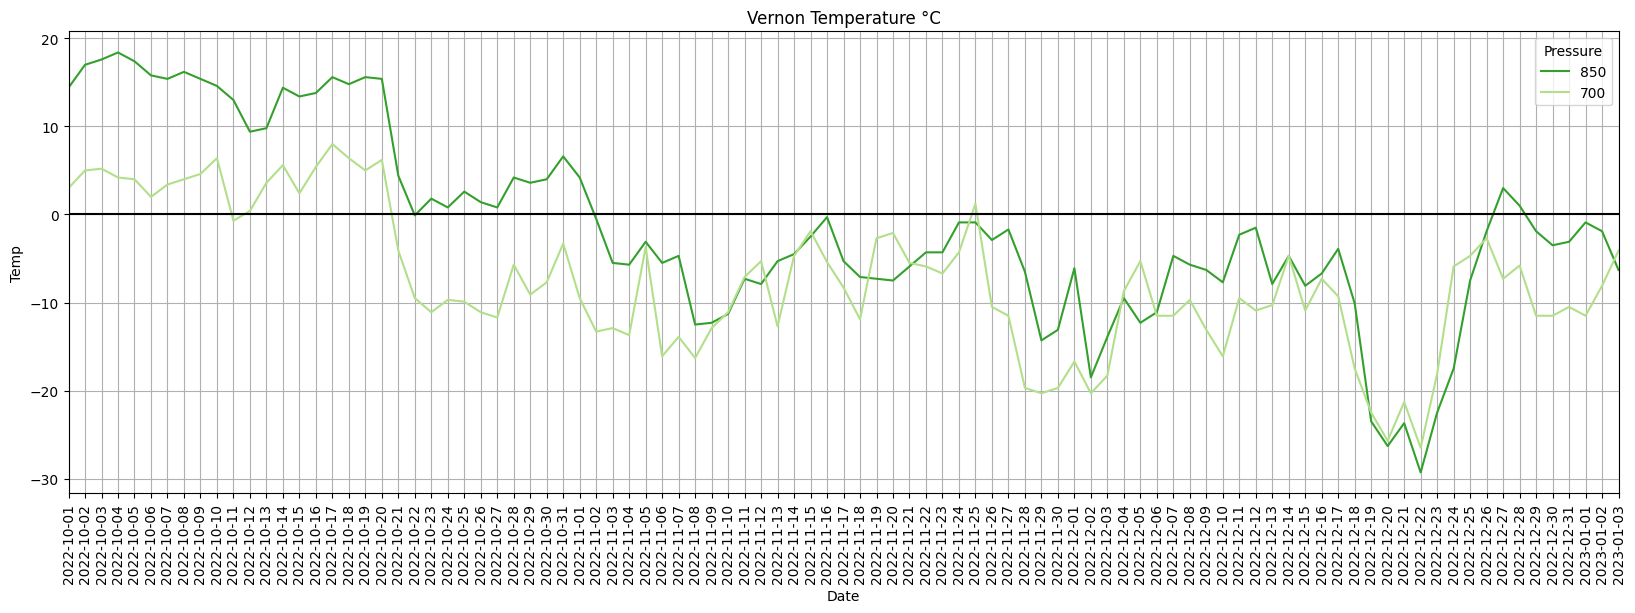

In [193]:
# Set figure details
plt.figure(figsize=(20,6))
plt.title("Vernon Temperature °C")
plt.xticks(rotation = 'vertical')
palette = sns.color_palette("Paired", n_colors=6)
order = [1, 0, 3, 2, 5, 4]
palette = [palette[idx] for idx in order]
hue_order = [850, 700]

# Line chart showing daily temps of Quillayute weather balloon at both 700 and 850 hPa
g = sns.lineplot(x='Date', y='Temp', hue='Pressure', data=df[df['Station'] == "Vernon"], palette=palette[2:4], hue_order=hue_order)
g.axhline(0, color='black')

# Display and Save graph
plt.xlim([0, len(df)/6 -1])
plt.grid()
plt.savefig("./figures/temp/VernonTemps-{:0>4d}-{:0>2d}-{:0>2d}.png".format(datetime.now().year, datetime.now().month, datetime.now().day),
                    format='png',dpi=150)
plt.show()

---
### Plot for Port Hardy
Plot for Temperature values at Port Hardy

---

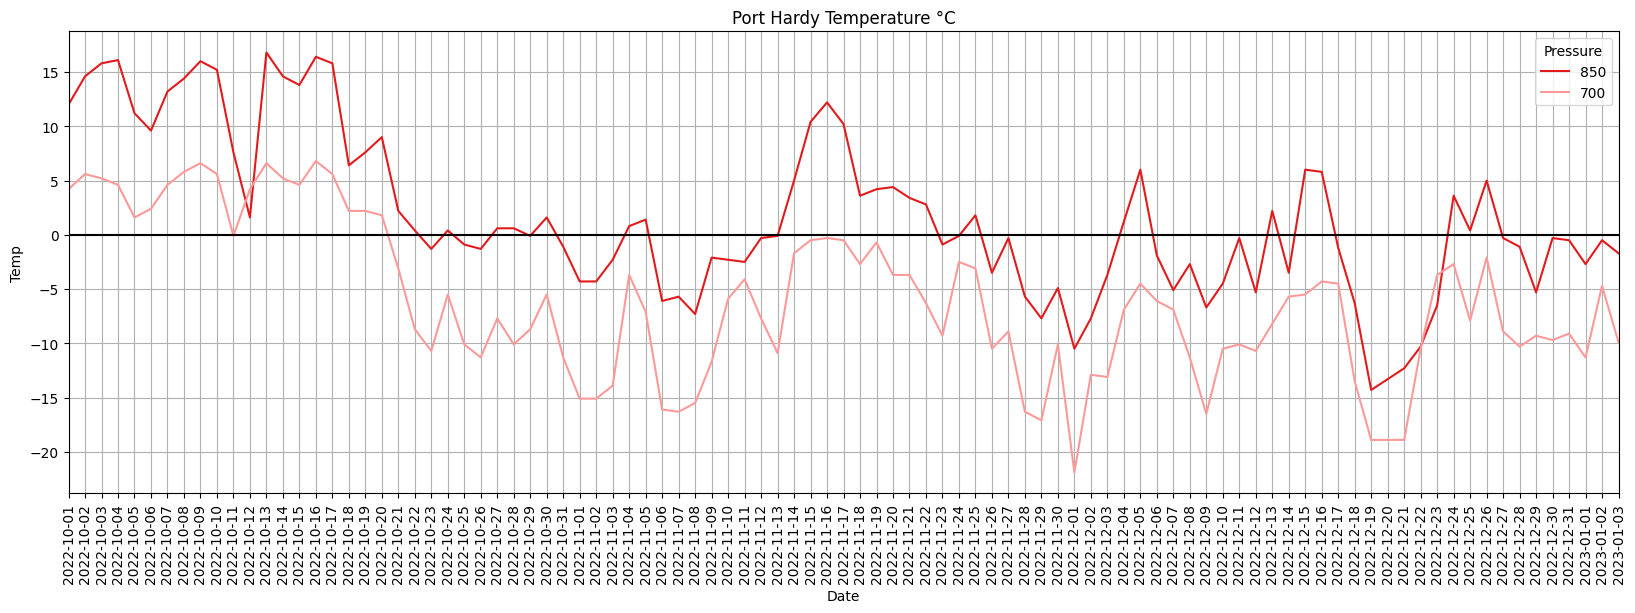

In [194]:
# Set figure details
plt.figure(figsize=(20,6))
plt.title("Port Hardy Temperature °C")
plt.xticks(rotation = 'vertical')
palette = sns.color_palette("Paired", n_colors=6)
order = [1, 0, 3, 2, 5, 4]
palette = [palette[idx] for idx in order]
hue_order = [850, 700]

# Line chart showing daily temps of Quillayute weather balloon at both 700 and 850 hPa
g = sns.lineplot(x='Date', y='Temp', hue='Pressure', data=df[df['Station'] == "Port Hardy"], palette=palette[4:6], hue_order=hue_order)
g.axhline(0, color='black')

# Display and Save graph
plt.xlim([0, len(df)/6 -1])
plt.grid()
plt.savefig("./figures/temp/PortHardyTemps-{:0>4d}-{:0>2d}-{:0>2d}.png".format(datetime.now().year, datetime.now().month, datetime.now().day),
                    format='png',dpi=150)
plt.show()

---
### Plot for All Stations
Tempterature readings for all stations plot on a single graph

---

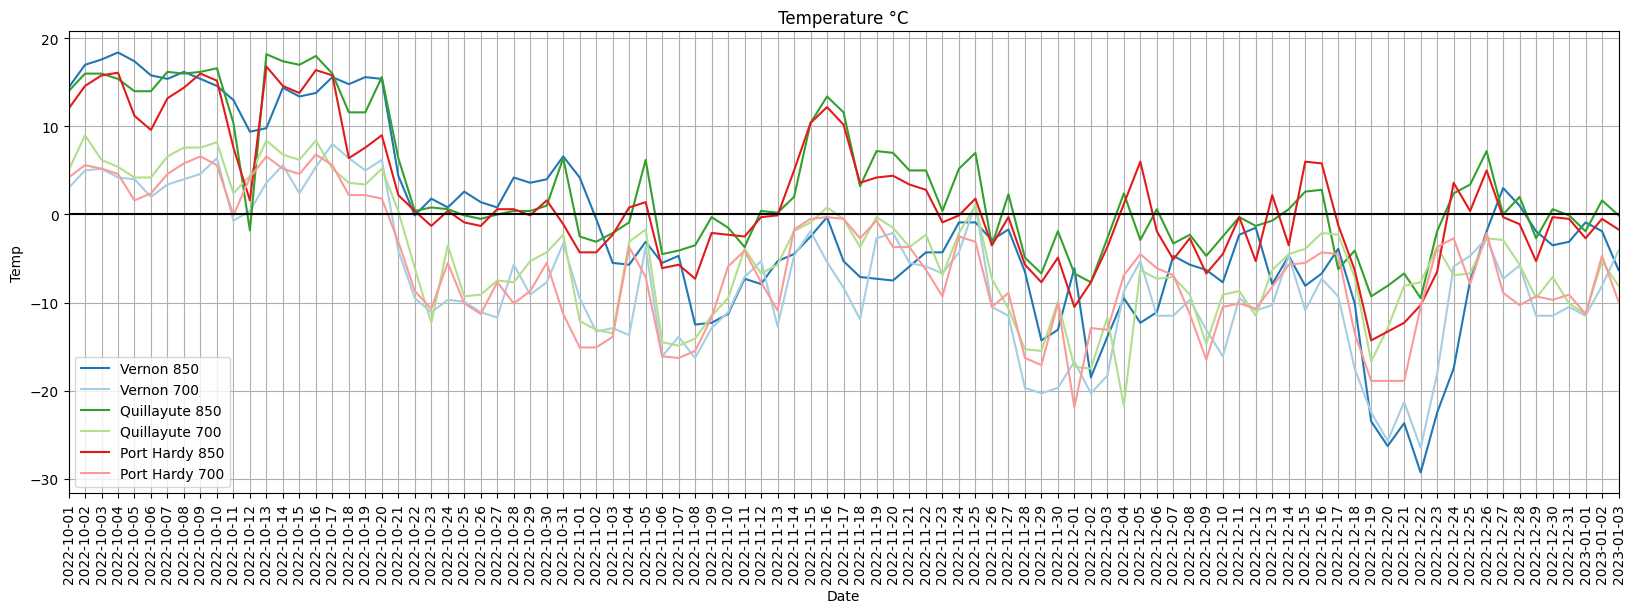

In [195]:
# Set figure details
plt.figure(figsize=(20,6))
plt.title("Temperature °C")
plt.xticks(rotation = 'vertical')

# Define desired order
order = [1, 0, 3, 2, 5, 4]
hue_order = [850, 700]

# Re-order color palette
palette = sns.color_palette("Paired", n_colors=6)
palette = [palette[idx] for idx in order]

# Re-order labels by desc pressure
labels=['Vernon 700', 'Vernon 850', 'Quillayute 700', 'Quillayute 850', 'Port Hardy 700', 'Port Hardy 850']
labels = [labels[idx] for idx in order]

# Line chart showing daily temps of Quillayute weather balloon at both 700 and 850 hPa
g = sns.lineplot(x='Date', y='Temp', hue='Pressure', data=df[df['Station'] == "Vernon"], palette=palette[:2], hue_order=hue_order)
g = sns.lineplot(x='Date', y='Temp', hue='Pressure', data=df[df['Station'] == "Quillayute"], palette=palette[2:4], hue_order=hue_order)
g = sns.lineplot(x='Date', y='Temp', hue='Pressure', data=df[df['Station'] == "Port Hardy"], palette=palette[4:6], hue_order=hue_order)
g.axhline(0, color='black')


# Rename legend with detailed labels
l = plt.legend()
for x, label in enumerate(labels):
    l.get_texts()[x].set_text(label)

# Display and Save graph
plt.xlim([0, len(df)/6 -1])
plt.grid()
plt.savefig("./figures/temp/PortHardyTemps-{:0>4d}-{:0>2d}-{:0>2d}.png".format(datetime.now().year, datetime.now().month, datetime.now().day),
                    format='png',dpi=150)
plt.show()

# Wind Plot
Using a wind rose, the direction and magnitude of wind from each region

In [196]:
# Function to truncate a colormap
# Can be used to remove white / black bookended values
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

## Plot for Quillayute
Plot for Wind Speed & Direction values at Vernon

---

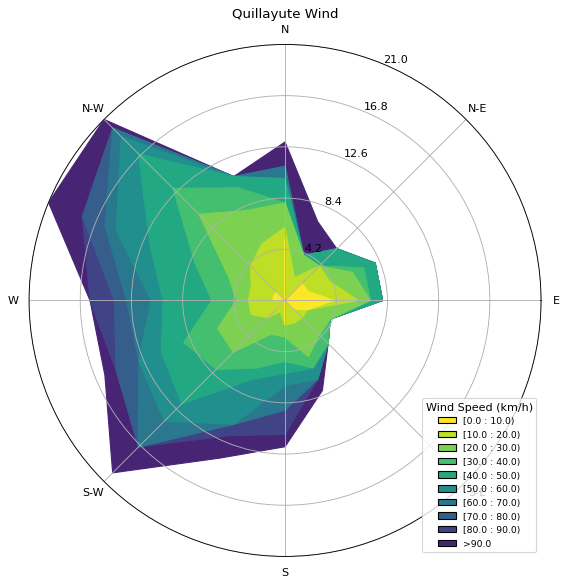

In [202]:
# Define color map and truncate to apropriate range
cmap = cm.viridis_r
cmap = truncate_colormap(cmap, minval=0, maxval=0.9)

# Populate speed and direction vars from DataFrame
wd = df[df['Station'] == "Quillayute"]['Wind_Direction'].to_list()
ws = df[df['Station'] == "Quillayute"]['Wind_Speed'].to_list()

# Plot wind rose for data set
ax = WindroseAxes.from_ax()
ax.contourf(wd, ws, bins=np.arange(0, 100, 10), cmap=cmap)
ax.set_legend()

# Save figure
plt.title("Quillayute Wind")
plt.legend(title="Wind Speed (km/h)", loc=4, fontsize='small', fancybox=True)
plt.savefig("./figures/wind/QuillayuteWind-{:0>4d}-{:0>2d}-{:0>2d}.png".format(datetime.now().year, datetime.now().month, datetime.now().day),
                    format='png',dpi=150)
plt.show()

## Plot for Vernon
Plot for Wind Speed & Direction values at Vernon

---

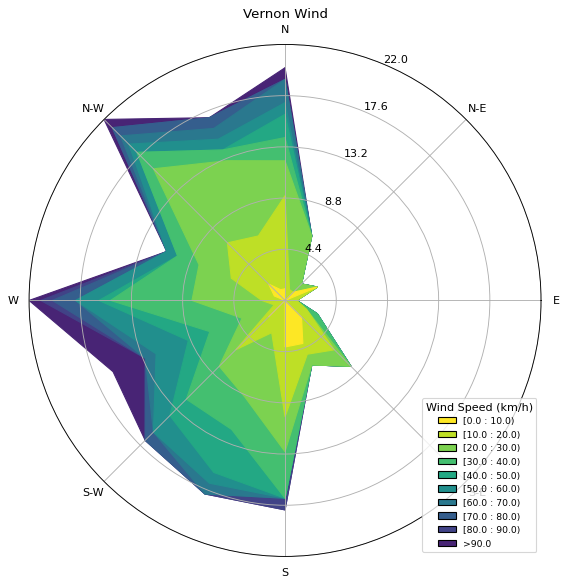

In [203]:
# Define color map and truncate to apropriate range
cmap = cm.viridis_r
cmap = truncate_colormap(cmap, minval=0, maxval=0.9)

# Populate speed and direction vars from DataFrame
wd = df[df['Station'] == "Vernon"]['Wind_Direction'].to_list()
ws = df[df['Station'] == "Vernon"]['Wind_Speed'].to_list()

# Plot wind rose for data set
ax = WindroseAxes.from_ax()
ax.contourf(wd, ws, bins=np.arange(0, 100, 10), cmap=cmap)
ax.set_legend()

# Save figure
plt.title("Vernon Wind")
plt.legend(title="Wind Speed (km/h)", loc=4, fontsize='small', fancybox=True)
plt.savefig("./figures/wind/VernonWind-{:0>4d}-{:0>2d}-{:0>2d}.png".format(datetime.now().year, datetime.now().month, datetime.now().day),
                    format='png',dpi=150)
plt.show()

## Plot for Port Hardy
Plot for Wind Speed & Direction values at Port Hardy

---

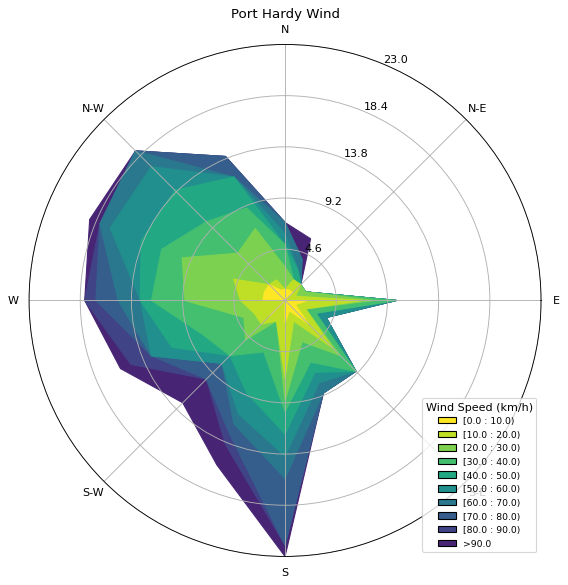

In [204]:
# Define color map and truncate to apropriate range
cmap = cm.viridis_r
cmap = truncate_colormap(cmap, minval=0, maxval=0.9)

# Populate speed and direction vars from DataFrame
wd = df[df['Station'] == "Port Hardy"]['Wind_Direction'].to_list()
ws = df[df['Station'] == "Port Hardy"]['Wind_Speed'].to_list()

# Plot wind rose for data set
ax = WindroseAxes.from_ax()
ax.contourf(wd, ws, bins=np.arange(0, 100, 10), cmap=cmap)
ax.set_legend()

# Save figure
plt.title("Port Hardy Wind")
plt.legend(title="Wind Speed (km/h)", loc=4, fontsize='small', fancybox=True)
plt.savefig("./figures/wind/PortHardyWind-{:0>4d}-{:0>2d}-{:0>2d}.png".format(datetime.now().year, datetime.now().month, datetime.now().day),
                    format='png',dpi=150)
plt.show()

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
#  ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ NOTES ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

## APP (2)

Easy to read / on the go / big text

700 | 3020m | -7 |
- - - - - - - - -
850 | 1590m | -9 |

Wind direction in an arrow // color coded magnitude and direction


Gathering data from brohm ridge needs to be done hourly
- looking like avalanche canada page on Wx


## Drive (1)
Guide daily forms
- Integrate to slack

Users need to see
- Just the weather info


## Webcms (3)
(load one by one -- javascript)
- cayoosh
- whistler peak
- blackcomb
- rubble creek
- brohm ridge
- s2s


western developement fund of canada /// Western Economic Diversification Canada

In [ ]:
table = [dates]
dates = [locations]
location = [variables]